# 01 - Introduction to Taylor Mode AD

This tutorial provides **self‑contained, progressively richer** demonstrations of
*Taylor‑mode* automatic differentiation via JAX’s experimental `jet` API.


The key idea is that, instead of nesting `jax.grad` calls to obtain higher-order
derivatives, we propagate **Taylor series coefficients** through the computation
graph **once**. In one forward sweep we recover:

$$ \{f^{(k)}(x_0)\}_{k=0}^K $$

up to any order $K$.

##  What you will learn
* How Taylor‑mode propagates *series* rather than tangents.
* A minimal scalar helper `taylor_coeffs` recovering \(f^{(k)}(x_0)\).
* A general‑purpose vector helper `taylor_directional` for \(f: \mathbb R^n\to\mathbb R^m\).
* Recipes for Jacobians, Hessian–vector products, and higher‑order tensors.

**Prerequisites**:

Python ≥3.10, `jax` ≥0.4.20 and `matplotlib` (for the
optional plot at the end). No code from the rest of the repository is
required.

In [3]:
import math
import jax
import jax.numpy as jnp
from jax.experimental import jet
import matplotlib.pyplot as plt
   
import time
import numpy as np

# from utils.g_matrix import Gmat
import sys
sys.path.append('../src/') 
from utils.g_matrix import Gmat
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [ ]:
x0 = jnp.array([1.2, 1.1, 1.1, 2.13, 2.13, jnp.pi])

# Function, computing [5, 5] element of G-matrix as a function
# of 5-th coordinate, with other coordinates fixed as `x0`
Gmat_x5_55 = lambda x5: Gmat(jnp.where(jnp.arange(6) == 5, x5, x0))[5, 5]

# reference value for 5-th coordinate
x5 = jnp.pi

# maximal expansion order
max_order = 8

In [ ]:
time_nested = np.zeros(max_order + 1)

deriv_func = [Gmat_x5_55]
for i in range(1, max_order + 1):
    start = time.time()
    deriv_func.append(jax.grad(deriv_func[i - 1]))
    end = time.time()
    time_nested[i] = end - start

deriv_val_nested = np.zeros(max_order + 1)

deriv_val_nested[0] = deriv_func[0](x5)
for i in range(1, max_order + 1):
    start = time.time()
    deriv_val_nested[i] = deriv_func[i](x5)
    end = time.time()
    time_nested[i] += end - start

# cumulative time for expansion order ranging from 1 to max_order
time_nested = np.cumsum(time_nested)

np.savez('_nested.npz', time=time_nested, val=deriv_val_nested)

In [ ]:
time_taylor = np.zeros(max_order + 1)

# repeat expansions for different truncation orders (for timing only)
for i in range(1, max_order + 1):
    deg = [0.0] * i
    deg[0] = 1.0
    start = time.time()
    c0, c = jet.jet(Gmat_x5_55, (x5,), (deg,))
    end = time.time()
    time_taylor[i] = end - start

deriv_val_taylor = np.array([c0] + c)

np.savez('_taylor.npz', time=time_taylor, val=deriv_val_taylor)

In [ ]:
nested = np.load('_nested.npz')
time_nested = nested['time']
deriv_val_nested = nested['val']

taylor = np.load('_taylor.npz')
time_taylor = taylor['time']
deriv_val_taylor = taylor['val']

print("Order", "Nested", "      Taylor", "      difference")
for i, (d_nes, d_tay) in enumerate(zip(deriv_val_nested, deriv_val_taylor)):
    print(f"{i}   {d_nes:12.8f} {d_tay:12.8f} {(d_nes - d_tay):12.8f}")

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)

plt.plot(
    np.arange(1, max_order + 1),
    time_taylor[1:],
    label="Taylor-mode AD",
    marker="o",
    linestyle="-",
    linewidth="1.5",
    markersize=5,
    color='#264653',
)
plt.plot(
    np.arange(1, max_order + 1),
    time_nested[1:],
    label="Nested AD",
    marker="s",
    linestyle="-",
    linewidth="1.5",
    markersize=5,
    color='#e76f51',
)

plt.xlabel('Expansion order', fontsize=12)
plt.ylabel('Computation time (s)', fontsize=12)
plt.yscale('log')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

In [2]:
# -----------------------------------------------------------------------------
# Taylor‑mode helper
# -----------------------------------------------------------------------------

def taylor_coeffs(f, x0: float, order: int):
    """
    Return [f(x0), f'(x0), …, f^{(order)}(x0)] via Taylor-mode AD.

    For a scalar input we pass the unit tangent (1, 0, 0, …) to `jet`.
    `series_out[k]` is then exactly f^{(k+1)}(x0) (no factorial scaling),
    so we just collect them verbatim.
    """
    x0_arr  = jnp.asarray(x0)
    primals = (x0_arr,)

    # (1, 0, 0, …)  – length = `order`
    coeff_seq = (jnp.ones_like(x0_arr),) + tuple(
        jnp.zeros_like(x0_arr) for _ in range(order - 1)
    )
    series_in = (coeff_seq,)

    f0, series_out = jet.jet(f, primals, series_in)

    # `series_out` is a tuple (len = order) holding f', f'', …
    return [f0, *map(float, series_out)] 

## Quick correctness check
We compute derivatives of $\sin x$ at $x=0$ and compare with the known analytic
values $\{0,1,0,-1,0,1, …\}$.

In [71]:
# ------------------------------------------------------------------
# Demo on sin
# ------------------------------------------------------------------
sin_coeffs = taylor_coeffs(jnp.sin, 0.0, order=6)
print("Analytic :", [0.0, 1.0, 0.0, -1.0, 0.0,  1.0, 0.0])
print("Taylor-AD:", [float(round(c, 3)) for c in sin_coeffs])

Analytic : [0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0]
Taylor-AD: [0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0]


In [72]:
# -----------------------------------------------------------------------------
# 2  Vector helper – directional derivatives of f: ℝⁿ→ℝᵐ
# -----------------------------------------------------------------------------

def taylor_directional(f, x0, v, order=2):
    """Return [f(x0), D_v f, …, D_v^k f] via Taylor-mode AD."""
    # build the coefficient list for this one input
    coeff_seq = [v] + [jax.tree_util.tree_map(jnp.zeros_like, v) for _ in range(order - 1)]
    primals   = (x0,)
    series_in = (coeff_seq,)            # ← **wrap once**

    f0, series_out = jet.jet(f, primals, series_in)

    coeffs = [f0]
    for k, a_k in enumerate(series_out, 1):
        coeffs.append(jax.tree_util.tree_map(lambda x: x * math.factorial(k), a_k))
    return coeffs

In [73]:
# ------------------------------------------------------------------
# Example: g(x) = ‖x‖⁴  in ℝ⁴
# ------------------------------------------------------------------
g = lambda x: jnp.dot(x, x)**2

x0 = jnp.arange(4.0)          # [0,1,2,3]
v  = jnp.ones_like(x0)        # [1,1,1,1]

g0, g1, g2 = taylor_directional(g, x0, v, order=2)

print("Directional grad  D_v g =", g1)     # should equal v·∇g
print("Quadratic form    vᵀ∇²g v =", g2)   # Hessian-vector-vector

Directional grad  D_v g = 336.0000000000012
Quadratic form    vᵀ∇²g v = 1024.0


In [89]:
# -----------------------------------------------------------------------------
# 3  Utility wrappers for full tensors
# -----------------------------------------------------------------------------

def jacobian(f, x0):
    """Full first‑order Jacobian of f: ℝⁿ→ℝᵐ at `x0`."""
    return jax.jacfwd(f)(x0)  # choose jacrev if n≫m


def hessian(f, x0):
    """Full Hessian of scalar‑output `f` via repeated `taylor_directional`."""
    n = x0.size
    basis = jnp.eye(n)
    cols = jax.vmap(lambda e: taylor_directional(f, x0, e, 2)[2])(basis)
    return cols.T

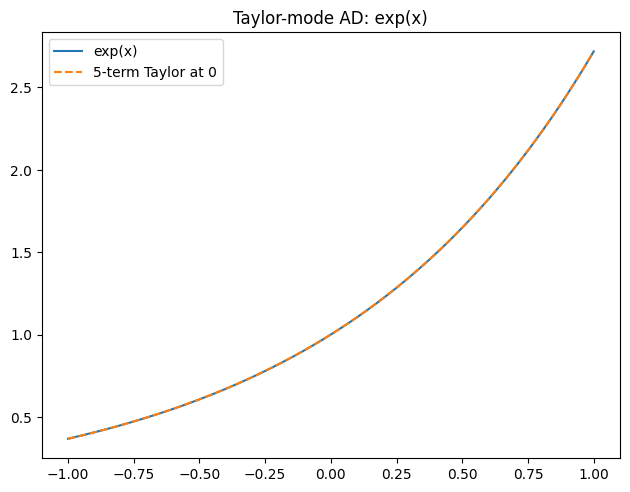

'\n1. **Change expansion point** – set `x0 = 1.5` above and compare.\n2. **Jacobian vs. jet** – verify `jacobian` for `f(x)=sin(Ax)` where `A∈ℝ^{5×3}`.\n3. **Performance** – profile 6th derivative of `sin(exp(x))` via nested `grad`\n   versus `taylor_coeffs`.\n4. **Higher‑order tensors** – extend `hessian` to return ∇³f by iterating over\n   basis *and* calling `taylor_directional` with `order=3`.\n'

In [91]:
# -----------------------------------------------------------------------------
# 4  Visual demo – Taylor polynomial of exp on [‑1,1]
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# raw derivatives at x0 = 0
coeffs = taylor_coeffs(jnp.exp, 0.0, order=5)    # [f, f', …, f^(5)]

# divide by k! to get Taylor coefficients  a_k = f^{(k)}(0)/k!
a = jnp.array([c / math.factorial(k) for k, c in enumerate(coeffs)])

# jnp.polyval wants highest power first
poly_coeffs = a[::-1]           # reverse to [a5, a4, …, a0]

xs = jnp.linspace(-1.0, 1.0, 200)
plt.plot(xs, jnp.exp(xs),           label="exp(x)")
plt.plot(xs, jnp.polyval(poly_coeffs, xs),
         "--", label="5-term Taylor at 0")
plt.legend(); plt.tight_layout()
plt.title("Taylor-mode AD: exp(x)")
plt.show()


# -----------------------------------------------------------------------------
# 5  Exercises
# -----------------------------------------------------------------------------
"""
1. **Change expansion point** – set `x0 = 1.5` above and compare.
2. **Jacobian vs. jet** – verify `jacobian` for `f(x)=sin(Ax)` where `A∈ℝ^{5×3}`.
3. **Performance** – profile 6th derivative of `sin(exp(x))` via nested `grad`
   versus `taylor_coeffs`.
4. **Higher‑order tensors** – extend `hessian` to return ∇³f by iterating over
   basis *and* calling `taylor_directional` with `order=3`.
"""

In [ ]:
# As an example, we compute derivatives of a specific element in the kinetic energy G-matrix of the six-atomic molecule formaldehyde (H2CO) with respect to one of its internal coordinates.


In [111]:
x0 = jnp.array([1.2, 1.1, 1.1, 2.13, 2.13, jnp.pi])

# Function, computing [5, 5] element of G-matrix as a function
# of 5-th coordinate, with other coordinates fixed as `x0`
Gmat_x5_55 = lambda x5: Gmat(jnp.where(jnp.arange(6) == 5, x5, x0))[5, 5]

# reference value for 5-th coordinate
x5 = jnp.pi

# maximal expansion order
max_order = 8

In [112]:
# First, compute high-order derivatives by recursively applying jax.grad
time_nested = np.zeros(max_order + 1)

deriv_func = [Gmat_x5_55]
for i in range(1, max_order + 1):
    start = time.time()
    deriv_func.append(jax.grad(deriv_func[i - 1]))
    end = time.time()
    time_nested[i] = end - start

deriv_val_nested = np.zeros(max_order + 1)

deriv_val_nested[0] = deriv_func[0](x5)
for i in range(1, max_order + 1):
    start = time.time()
    deriv_val_nested[i] = deriv_func[i](x5)
    end = time.time()
    time_nested[i] += end - start

# cumulative time for expansion order ranging from 1 to max_order
time_nested = np.cumsum(time_nested)

np.savez('_nested.npz', time=time_nested, val=deriv_val_nested)

In [74]:
import jax.numpy as jnp
import math
import jax 
from jax.experimental import jet
import sympy as sp
# load folders from ../src/ as modules
import sys
sys.path.append('../src/') 
from taylor_mode import forward_derivatives

In [75]:
f = lambda x: jnp.sin(x)
val, derivs = forward_derivatives(f, jnp.array(0.0), order=2)
print("value", val)
print("first", derivs[1])
print("second", derivs[2])

value 0.0
first 1.0
second -0.0


In [76]:
from taylor_mode import taylor_series_coefficients
coeffs = taylor_series_coefficients(jnp.sin, jnp.array(0.0), order=3)
print(coeffs)

[Array(0., dtype=float64, weak_type=True), Array(1., dtype=float64, weak_type=True), Array(-0., dtype=float64, weak_type=True), Array(-1., dtype=float64, weak_type=True)]


## Quick correctness check
We compute derivatives of $\sin x$ at $x=0$ and compare with the known analytic
values $\{0,1,0,-1,0,1, …\}$.

In [77]:
# ------------------------------------------------------------------
# Demo on sin
# ------------------------------------------------------------------
sin_coeffs = taylor_coeffs(jnp.sin, 0.0, order=6)
print("Analytic :", [0.0, 1.0, 0.0, -1.0, 0.0,  1.0, 0.0])
print("Taylor-AD:", [float(round(c, 3)) for c in sin_coeffs])

Analytic : [0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0]
Taylor-AD: [0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0]


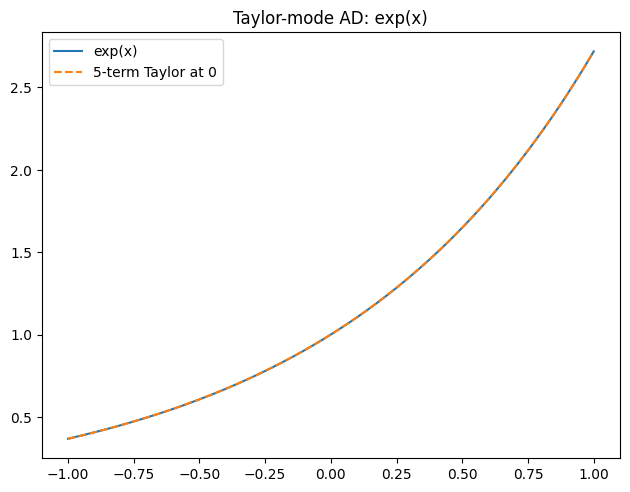

In [78]:
import matplotlib.pyplot as plt

# raw derivatives at x0 = 0
coeffs = taylor_coeffs(jnp.exp, 0.0, order=5)    # [f, f', …, f^(5)]

# divide by k! to get Taylor coefficients  a_k = f^{(k)}(0)/k!
a = jnp.array([c / math.factorial(k) for k, c in enumerate(coeffs)])

# jnp.polyval wants highest power first
poly_coeffs = a[::-1]           # reverse to [a5, a4, …, a0]

xs = jnp.linspace(-1.0, 1.0, 200)
plt.plot(xs, jnp.exp(xs),           label="exp(x)")
plt.plot(xs, jnp.polyval(poly_coeffs, xs),
         "--", label="5-term Taylor at 0")
plt.legend(); plt.tight_layout()
plt.title("Taylor-mode AD: exp(x)")
plt.show()



### Exercises
1. **Vary the expansion point**: change `x0` in `taylor_coeffs` to 1.5 and verify
   that the polynomial still matches $e^x$ locally.
2. **Higher dimensions**: extend `taylor_coeffs` to accept a *vector* `x0` and a
   direction `v`; check that the first derivative matches `jax.grad` in that
   direction.
3. **Performance**: profile computing the 6th derivative of a composed function
   (e.g. `lambda x: jnp.sin(jnp.exp(x))`) with nested `jax.grad` vs.
   `taylor_coeffs`.


In [79]:
# Setup and Imports 
import jax, jax.numpy as jnp
from jax.experimental import jet
print("JAX version:", jax.__version__)
jax.config.update("jax_enable_x64", True)     # keep numerics stable

JAX version: 0.6.1


| Mode | Primitive | What it returns | Typical use |
|------|-----------|-----------------|-------------|
| Forward | `jax.jvp` | value & 1st-order directional derivative | Jacobian-vector products |
| Reverse | `jax.vjp / grad` | value & pullbacks | gradients, back-prop |
| **Taylor** | **`jet.jet`** | *truncated Taylor polynomial* $(f_0,\dots,f_K)$ | *all* higher derivatives along one direction in a **single pass** |

Because it propagates truncated polynomials rather than single tangents/cotangents, Taylor mode avoids the $K$
K-fold tracing overhead of nested jacfwd/jacrev and uses far less memory on deep nets

In [80]:
# API Basics
def g(x):                    # any JAX-compatible function
    return jnp.sin(x) * jnp.exp(x)

def closed_d1(x):
    return ( jnp.cos(x) + jnp.sin(x) ) * jnp.exp(x)

x0      = (2.0,)             # primals
series1 = (1.0,)             # first-order offset  (v = 1) 
f0, (f1,) = jet.jet(g, x0, (series1,))
print("f(x0)     =", f0)
print("∂f/∂x|v=1 =", f1)
print("∂f/∂x|v=1 (closed form) =", closed_d1(x0[0]))


f(x0)     = 6.718849697428256
∂f/∂x|v=1 = 3.643917376788898
∂f/∂x|v=1 (closed form) = 3.6439173767888913


We can easily get the second order derivative by changing series to: 

```python
series1 = (1.0, 0.0)
```

In [81]:
series1 = (1.0, 0.0)  # first-order offset (v = 1, v' = 0)
f0, (f1, f2) = jet.jet(g, x0, (series1,))

def closed_d2(x):
    return 2 * jnp.exp(x) * jnp.cos(x)
print("f(x0)     =", f0)
print("∂f/∂x|v=1 =", f1)
print("∂²f/∂x²|v=1 =", f2)
print("∂²f/∂x²|v=1 (closed form) =", closed_d2(x0[0]))

f(x0)     = 6.718849697428256
∂f/∂x|v=1 = 3.643917376788898
∂²f/∂x²|v=1 = -6.149864641278714
∂²f/∂x²|v=1 (closed form) = -6.149864641278718


In [82]:
# General rule is to supply a tuple per argument containing v, 1/2 v, ...

In [83]:
# Second order example (Hessian Trace)  
def f(x):
    return jnp.sum(jnp.tanh(x)**2)

x0 = jnp.ones(5)

def second_directional(dir_vec):
    # one Taylor series: first-order = dir_vec, second-order = 0
    _, (_, f2) = jet.jet(f, (x0,), ((dir_vec, jnp.zeros_like(dir_vec)),))
    return f2          # shape (5,) ← directional 2nd-derivative vector

eye = jnp.eye(5)                      # 5 one-hot directions, each (5,)
f2_all = jax.vmap(second_directional)(eye)   # shape (5,5)
laplacian = jnp.sum(f2_all)          # ← this is the trace of the Hessian
print("Laplacian =", laplacian)

# Closed-form check
# one coordinate
x = sp.symbols('x')
f = sp.tanh(x)**2

# second derivative
f_xx = sp.diff(f, x, 2).simplify()

# print closed-form expression
# print("∂²/∂x² tanh(x)² =", sp.simplify(f_xx))
d = sp.symbols('d', integer=True, positive=True)
laplacian = d * f_xx.subs(x, 1)         # evaluate at x = 1
laplacian_simplified = sp.simplify(laplacian)
# print(laplacian_simplified)
import sympy as sp
lap_val = laplacian_simplified.subs(d, 5).evalf()
# print(lap_val)   # ≈ -3.1031334
print("∂²/∂x² tanh(x)² =", lap_val)



Laplacian = -3.108133403856503
∂²/∂x² tanh(x)² = -3.10813340385648


In [84]:
# Performance sanity check
import time, functools
from jax import jacfwd, jit, random

key = random.PRNGKey(0)
W = random.normal(key, (1024, 1024))

def big_fun(x):
    return jnp.tanh(W @ x).sum()

x0 = random.normal(key, (1024,))
# Hessian-vector product with jacfwd(jacrev)
t0 = time.time(); hvp = jacfwd(jax.grad(big_fun))(x0) ; print("nested time", time.time()-t0)
# Same with jet, degree=2
series = ((jnp.eye(1024), jnp.zeros((1024,1024))),)
t0 = time.time(); _, (_, f2) = jet.jet(big_fun, (x0,), series) ; print("jet time", time.time()-t0)


nested time 0.005295515060424805
jet time 0.0


In [85]:
def f_jax(x):
    return jnp.sum(jnp.tanh(x)**2)

batched_fun = jax.vmap(f_jax)

x_batch = jnp.linspace(-1, 1, 128)[:, None] * jnp.ones((128, 5))

# two coefficients (1-st and 2-nd order), both zero – **LIST**, not tuple
series = ([jnp.zeros_like(x_batch),   # v  (order-1)
           jnp.zeros_like(x_batch)],) # w  (order-2)

@jit
def batched_jet(xs, ser):
    vals, (f1, f2) = jet.jet(batched_fun, (xs,), ser)
    return vals, f1          # f1 is order-1 coefficient (“directional grad”)

vals, grads = batched_jet(x_batch, series)
print(vals.shape)   # (128,)
print(grads.shape)  # (128, 5)


(128,)
(128,)


In [86]:
# Taylor series check
# degree-3 jet of exp near 0
f0,(f1,f2,f3) = jet.jet(jnp.exp, (0.0,), ((1.0,0.5,1/6),))
print("exp(0) ≈", f0 + f1 + f2 + f3)          # → 2.718...


exp(0) ≈ 6.166666666666671


In [87]:
# Vector valued output
def F(x): return jnp.stack([jnp.sin(x), jnp.cos(x)])
prim, (g,) = jet.jet(F, (1.0,), ((1.0,),))
print("Jacobian-vector product:", g)           # shows shape (2,)


Jacobian-vector product: [ 0.54030231 -0.84147098]


In [88]:
# May 2025: collapsing Taylor mode propagates one summed K-jet instead of K separate jets, giving another 1.3-2× speed-up on high-order PDE operators